# Setting up paths

In [ ]:
# Importing the os module for operating system-related functionality
import os

In [ ]:
# Custom model name for the project
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

# Pretrained model details
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# Script for generating TFRecord
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

# Label map file name
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
# Dictionary containing various paths used in the project
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Model'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
# Dictionary containing file paths
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# Loading Trained model from last Checkpoint

In [ ]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

# Function to perform object detection on an input image
@tf.function
def detect_fn(image):
    # Preprocess the input image
    image, shapes = detection_model.preprocess(image)
    
    # Make predictions
    prediction_dict = detection_model.predict(image, shapes)
    
    # Postprocess the predictions to get final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

# Detecting Objects from an Image

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Create a category index from the label map
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


In [ ]:

# Path to the image for detection
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'ThumbsUp.8cba580a-a897-11ee-ad3e-24ee9aa45474.jpg')


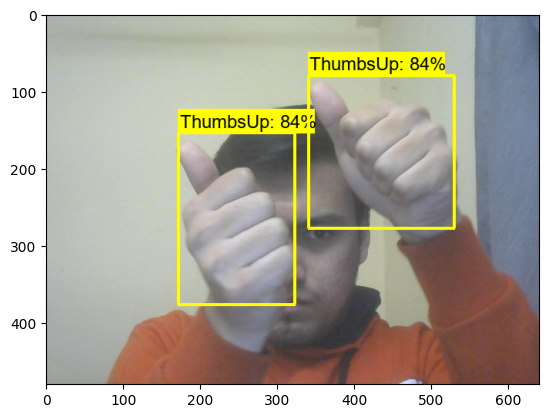

In [19]:
# Read the image using OpenCV
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

# Convert the image to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

# Perform object detection using the defined detection function
detections = detect_fn(input_tensor)

# Extract the number of detections and convert relevant data to numpy arrays
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Ensure detection classes are integers
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Create a copy of the image for visualization
image_np_with_detections = image_np.copy()

# Visualize the detected boxes and labels on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + 1,  # Adding 1 to align with category indices (0-based index)
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,  # Maximum number of boxes to draw on the image
    min_score_thresh=0.8,  # Minimum confidence score to consider a detection
    agnostic_mode=False  # If True, treat all classes as one (agnostic to class)
)

# Display the image with visualized detections using matplotlib
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Real Time Detections from Webcam

In [ ]:
# Open a connection to the webcam (assuming webcam index 0)
cap = cv2.VideoCapture(0)

# Get the frame dimensions
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Continuously process frames from the webcam
while cap.isOpened(): 
    # Read a frame from the webcam
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    # Convert the frame to a TensorFlow tensor
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Perform object detection on the frame
    detections = detect_fn(input_tensor)
    
    # Extract and preprocess the detection results
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Ensure detection classes are integers
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Create a copy of the frame for visualization
    image_np_with_detections = image_np.copy()

    # Visualize the detected boxes, labels, and scores on the frame
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + 1,  # Adding 1 to align with category indices (0-based index)
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,  # Maximum number of boxes to draw on the frame
        min_score_thresh=0.8,  # Minimum confidence score to consider a detection
        agnostic_mode=False  # If True, treat all classes as one (agnostic to class)
    )

    # Display the frame with visualized detections
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (800, 600)))
    
    # Check for the 'q' key to exit the loop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Freezing Graph

In [ ]:
# Path to the freezing script
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

# Construct the command for freezing the graph
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(
    FREEZE_SCRIPT, files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH']
)

# Execute the command to freeze the graph
!{command}
